In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
data = '''
# nelec  rs    nkpts        HF           CCD_corr             AFQMC/HF                AFQMC/CID             AFQMC/CCD_PT
#    14  5.0     19      -0.8125485     -0.13690349      -0.947382 +/- 0.000850  -0.953628 +/- 0.000488  -0.953763 +/- 0.000401
    14  5.0     57      -0.8125485     -0.22336843      -1.056076 +/- 0.000894  -1.063944 +/- 0.000607  -1.063780 +/- 0.000775
    14  5.0     93      -0.8125485     -0.24493419      -1.079162 +/- 0.000646  -1.090699 +/- 0.000867  -1.092355 +/- 0.000991
    14  5.0     171     -0.8125485     -0.25104848      -1.082545 +/- 0.000830  -1.096373 +/- 0.000599  -1.098375 +/- 0.000869
    14  5.0     257     -0.8125485     -0.25211065      -1.080541 +/- 0.001619  -1.096196 +/- 0.001492  -1.099143 +/- 0.000663
#    14  5.0     389     -0.8125485     -0.25273434
'''

In [3]:
m = np.array([])
hf = np.array([])
ccsd_corr = np.array([])
afqmc_hf = np.array([])
afqmc_ci = np.array([])
afqmc_pt = np.array([])
afqmc_hf_err = np.array([])
afqmc_ci_err = np.array([])
afqmc_pt_err = np.array([])
for lines in data.splitlines():
    if not lines.startswith('#') and len(lines) > 0:
        parts = lines.split()
        m = np.hstack((m,int(parts[2])))
        hf = np.hstack((hf,float(parts[3])))
        ccsd_corr = np.hstack((ccsd_corr,float(parts[4])))
        afqmc_hf = np.hstack((afqmc_hf,float(parts[5])))
        afqmc_hf_err = np.hstack((afqmc_hf_err,float(parts[7])))
        afqmc_ci = np.hstack((afqmc_ci,float(parts[8])))
        afqmc_ci_err = np.hstack((afqmc_ci_err,float(parts[10])))
        afqmc_pt = np.hstack((afqmc_pt,float(parts[11])))
        afqmc_pt_err = np.hstack((afqmc_pt_err,float(parts[13])))

afqmc_hf_corr = afqmc_hf - hf
afqmc_ci_corr = afqmc_ci - hf
afqmc_pt_corr = afqmc_pt - hf

In [4]:
# CCD
inv_m = 1/m
A = np.column_stack([inv_m**3, inv_m**2, np.ones_like(inv_m)])
(a1, b1, c1), residuals, rank, s = np.linalg.lstsq(A, ccsd_corr, rcond=None)

N = len(inv_m)
sigma2 = residuals[0] / (N - 3)      # variance of residuals
cov = sigma2 * np.linalg.inv(A.T @ A)

da1, db1, dc1 = np.sqrt(np.diag(cov))
print(f'CCD extralopation = {c1:.8f} +/- {dc1:.8f}')

# AFQMC/HF
inv_m = 1/m
A = np.column_stack([inv_m**3, inv_m**2, np.ones_like(inv_m)])
(a2, b2, c2), residuals, rank, s = np.linalg.lstsq(A, afqmc_hf_corr, rcond=None)

N = len(inv_m)
sigma2 = residuals[0] / (N - 3)      # variance of residuals
cov = sigma2 * np.linalg.inv(A.T @ A)

da2, db2, dc2 = np.sqrt(np.diag(cov))
print(f'AFQMC/HF extralopation = {c2:.8f} +/- {dc2:.8f}')

# AFQMC/CID
inv_m = 1/m
A = np.column_stack([inv_m**3, inv_m**2, np.ones_like(inv_m)])
(a3, b3, c3), residuals, rank, s = np.linalg.lstsq(A, afqmc_ci_corr, rcond=None)

N = len(inv_m)
sigma2 = residuals[0] / (N - 3)      # variance of residuals
cov = sigma2 * np.linalg.inv(A.T @ A)

da3, db3, dc3 = np.sqrt(np.diag(cov))
print(f'AFQMC/CID extralopation = {c3:.8f} +/- {dc3:.8f}')

# AFQMC/CCD_PT
inv_m = 1/m
A = np.column_stack([inv_m**3, inv_m**2, np.ones_like(inv_m)])
(a4, b4, c4), residuals, rank, s = np.linalg.lstsq(A, afqmc_pt_corr, rcond=None)

N = len(inv_m)
sigma2 = residuals[0] / (N - 3)      # variance of residuals
cov = sigma2 * np.linalg.inv(A.T @ A)

da4, db4, dc4 = np.sqrt(np.diag(cov))
print(f'AFQMC/CCD_PT extralopation = {c4:.8f} +/- {dc4:.8f}')

CCD extralopation = -0.25267285 +/- 0.00004270
AFQMC/HF extralopation = -0.26758792 +/- 0.00122904
AFQMC/CID extralopation = -0.28369998 +/- 0.00045307
AFQMC/CCD_PT extralopation = -0.28654739 +/- 0.00015271


In [5]:
x = inv_m
y = afqmc_hf_corr
y_err = afqmc_hf_err

# design matrix WITHOUT x term
A = np.column_stack([
    np.ones_like(x),   # a0
    x**2,              # a2
    x**3               # a3, etc.
])

# weights
W = np.diag(1 / y_err**2)

# weighted least squares
cov = np.linalg.inv(A.T @ W @ A)
coeffs = cov @ (A.T @ W @ y)
errors = np.sqrt(np.diag(cov))

print("coeff = ", coeffs)
print("error =", errors)

coeff =  [-2.68437084e-01 -8.94263264e+01  9.71459503e+03]
error = [1.27473269e-03 3.07142421e+01 1.58880647e+03]


In [6]:
def basis_ext(x,y,y_err=None):
    '''
    fitting Energy vs (num. of basis)^(-1)
    E(1/m) = a + b*(1/m)**2 + c*(1/m)**3
    '''
    A = np.column_stack([
        np.ones_like(x), 
        x**2, 
        x**3
        ])

    if y_err is not None:
        # weighted least squares
        W = np.diag(1 / y_err**2)
        cov = np.linalg.inv(A.T @ W @ A)
        (a,b,c) = cov @ (A.T @ W @ y)
        (da,db,dc) = np.sqrt(np.diag(cov))
    else:
        (a, b, c), residuals, rank, s = np.linalg.lstsq(A, y, rcond=None)

        N = len(x)
        sigma2 = residuals[0] / (N - 3)      # variance of residuals
        cov = sigma2 * np.linalg.inv(A.T @ A)
        (da,db,dc) = np.sqrt(np.diag(cov))

    return (a,b,c), (da,db,dc)

In [7]:
(a1,b1,c1), (da1,db1,dc1) = basis_ext(inv_m,ccsd_corr,y_err=None)
(a2,b2,c2), (da2,db2,dc2) = basis_ext(inv_m,afqmc_hf_corr,y_err=afqmc_hf_err)
(a3,b3,c3), (da3,db3,dc3) = basis_ext(inv_m,afqmc_ci_corr,y_err=afqmc_ci_err)
(a4,b4,c4), (da4,db4,dc4) = basis_ext(inv_m,afqmc_pt_corr,y_err=afqmc_pt_err)
print(f'CCD extralopation = {a1:.5f} +/- {da1:.5f}')
print(f'AFQMC/HF extralopation = {a2:.3f} +/- {da2:.3f}')
print(f'AFQMC/CID extralopation = {a3:.3f} +/- {da3:.3f}')
print(f'AFQMC/CCD_PT extralopation = {a4:.3f} +/- {da4:.3f}')

CCD extralopation = -0.25267 +/- 0.00004
AFQMC/HF extralopation = -0.268 +/- 0.001
AFQMC/CID extralopation = -0.284 +/- 0.001
AFQMC/CCD_PT extralopation = -0.287 +/- 0.001


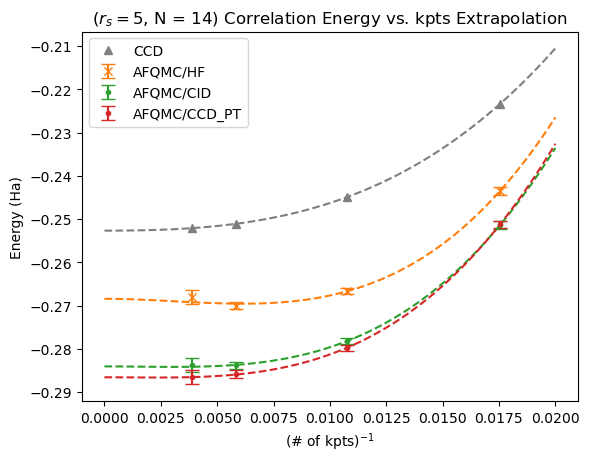

In [21]:
x = np.linspace(0,0.02,100)
y1 = a1 + b1*x**2 + c1*x**3
y2 = a2 + b2*x**2 + c2*x**3
y3 = a3 + b3*x**2 + c3*x**3
y4 = a4 + b4*x**2 + c4*x**3

plt.plot(inv_m,ccsd_corr,'^',color='C7',label='CCD')
plt.errorbar(inv_m,afqmc_hf_corr,yerr=afqmc_hf_err,fmt='x',capsize=5,color='C1',label='AFQMC/HF')
plt.errorbar(inv_m,afqmc_ci_corr,yerr=afqmc_hf_err,fmt='.',capsize=5,color='C2',label='AFQMC/CID')
plt.errorbar(inv_m,afqmc_pt_corr,yerr=afqmc_hf_err,fmt='.',capsize=5,color='C3',label='AFQMC/CCD_PT')
plt.plot(x,y1,'--',color='C7',label='CCD(fit)')
plt.plot(x,y2,'--',color='C1',label='AFQMC/HF(fit)')
plt.plot(x,y3,'--',color='C2',label='AFQMC/CID(fit)')
plt.plot(x,y4,'--',color='C3',label='AFQMC/CCD_PT(fit)')
plt.xlabel('(# of kpts)$^{-1}$')
plt.ylabel('Energy (Ha)')
plt.title('($r_s = 5$, N = 14) Correlation Energy vs. kpts Extrapolation')
handles, labels = plt.gca().get_legend_handles_labels()
order = ['CCD', 'AFQMC/HF', 'AFQMC/CID', 'AFQMC/CCD_PT']
ordered_handles = [handles[labels.index(l)] for l in order]
ordered_labels = order
plt.legend(ordered_handles, ordered_labels,loc='upper left')
plt.show()